In [1]:
import pandas as pd
import numpy as np
import cdt
import networkx as nx
import os

from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.cit import fisherz

# Importing necessary libraries

Detecting 8 CUDA device(s).


In [2]:
data_dir = '/cim/ehoney/IFT6168_project/dcdi/data/perfect/data_p10_e10_n10000_linear_struct'

In [3]:
def convert_cpdag_format(causal_graph):
    """
    Convert the CPDAG format from CausalGraph (cg.G.graph) to an adjacency matrix format.
    
    Args:
        causal_graph: A CausalGraph object with cg.G.graph as the adjacency matrix.
    
    Returns:
        A NumPy adjacency matrix where:
        - 1 represents an edge (directed or undirected).
        - 0 represents no edge.
    """
    # Extract the graph matrix
    graph_matrix = causal_graph.G.graph
    n = graph_matrix.shape[0]
    
    # Initialize the adjacency matrix
    adjacency_matrix = np.zeros((n, n), dtype=int)
    
    for i in range(n):
        for j in range(n):
            if graph_matrix[j, i] == 1 and graph_matrix[i, j] == -1:
                # Directed edge i -> j
                adjacency_matrix[i, j] = 1
            elif graph_matrix[i, j] == -1 and graph_matrix[j, i] == -1:
                # Undirected edge i -- j
                adjacency_matrix[i, j] = 1
                adjacency_matrix[j, i] = 1
            elif graph_matrix[i, j] == 1 and graph_matrix[j, i] == 1:
                # Bidirectional edge i <-> j
                adjacency_matrix[i, j] = 1
                adjacency_matrix[j, i] = 1
    
    return adjacency_matrix

# PC algorithm

## Test run

In [4]:
dag_path = os.path.join(data_dir, 'DAG1.npy')
cpdag_path = os.path.join(data_dir, 'CPDAG1.npy')
obs_data_path = os.path.join(data_dir, 'data1.npy')
interv_data_path = os.path.join(data_dir, 'data_interv1.npy')
regime_idx_path = os.path.join(data_dir, 'regime1.csv')
interv_nodes_path = os.path.join(data_dir, 'intervention1.csv')

In [5]:
dag = np.load(dag_path)
dag

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [6]:
cpdag = np.load(cpdag_path)
cpdag

array([[0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0., 1., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [7]:
obs_data = np.load(obs_data_path)
obs_data

array([[ 1.04549416,  1.56876855,  0.50505903, ..., -1.55214666,
        -0.67011774, -0.95467569],
       [ 0.83139287,  0.29945842, -0.56516481, ..., -0.82588713,
        -1.0324189 , -0.20330703],
       [-1.53261836, -2.29737887,  0.70926069, ...,  1.30303601,
         2.05855852,  0.90334801],
       ...,
       [-1.68027651, -1.29201461,  0.36296983, ...,  0.20386925,
         0.3136674 ,  1.03691721],
       [ 0.73037723,  0.7762301 ,  0.5579628 , ..., -0.08943212,
        -1.72667629, -0.31639158],
       [-2.34830366, -2.29520103, -0.47288351, ...,  1.47536252,
         1.07835087,  2.56914919]])

In [8]:
# Load data frame from csv regime_idx_path
regime_df = pd.read_csv(regime_idx_path)
regime_df

,10
0,10
1,10
2,10
3,10
4,10
...,...
9994,0
9995,0
9996,0
9997,0


In [9]:
# Load data frame from csv interv_nodes_path, but load even empty rows
# and fill them with NaN
# Use the dtype parameter to specify the data type for each column
interv_nodes_df = pd.read_csv(interv_nodes_path)
interv_nodes_df

,0
0,0
1,0
2,0
3,0
4,0
...,...
9085,3
9086,3
9087,3
9088,3


In [10]:
cg = pc(obs_data)
GraphUtils.to_pydot(cg.G).write_png("pc_graph.png")

  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
cg.G.graph

array([[ 0, -1,  0,  0, -1,  0,  0,  0,  0, -1],
       [-1,  0,  0,  0, -1,  0,  0, -1, -1,  0],
       [ 0,  0,  0, -1,  0,  0,  0,  0,  0,  0],
       [ 0,  0, -1,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, -1,  0,  0,  0,  0,  0],
       [ 0, -1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, -1,  0,  0,  0,  0,  0,  0,  0,  0],
       [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [12]:
convert_cpdag_format(cg)

array([[0, 1, 0, 0, 1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [13]:
cpdag

array([[0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0., 1., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [17]:
cpdag[0,0]=1

In [19]:
cdt.metrics.SHD(cpdag, convert_cpdag_format(cg), double_for_anticausal=False)

0.5

## Production

In [5]:
# Dictionary to store SHD values and statistics for each data directory
shd_stats_per_dir = {}

# List of data directories to iterate through
data_dirs = [
    os.path.join('/cim/ehoney/ift6168_project_v2/ift6168_project/data/perfect', d)
    for d in os.listdir('/cim/ehoney/ift6168_project_v2/ift6168_project/data/perfect')
    if os.path.isdir(os.path.join('/cim/ehoney/ift6168_project_v2/ift6168_project/data/perfect', d))
    and d != 'sachs_intervention' and not d.endswith('.zip')
]

# Iterate through each data directory
for data_dir in data_dirs:
    print(f"Processing data directory: {data_dir}")
    
    shd_values = []  # Reset SHD values for the current directory
    
    # Iterate through the 10 datasets in the current directory
    for i in range(1, 11):
        # Load the DAG, CPDAG, and observational data
        dag_path = os.path.join(data_dir, f'DAG{i}.npy')
        cpdag_path = os.path.join(data_dir, f'CPDAG{i}.npy')
        obs_data_path = os.path.join(data_dir, f'data{i}.npy')
        
        dag = np.load(dag_path)
        cpdag = np.load(cpdag_path)
        obs_data = np.load(obs_data_path)
        
        # Estimate the CPDAG using the PC algorithm
        cg = pc(obs_data)
        
        # Convert the estimated CPDAG to adjacency matrix format
        estimated_cpdag = convert_cpdag_format(cg)
        
        # Compute the SHD
        shd = np.sum(estimated_cpdag != cpdag)
        shd_values.append(shd)
        
        # Print the SHD for the current dataset
        print(f"Dataset {i}: SHD = {shd}")
    
    # Compute the mean and variance of SHD values for the current directory
    mean_shd = np.mean(shd_values)
    variance_shd = np.var(shd_values)
    
    # Store the full SHD values and statistics in the dictionary
    shd_stats_per_dir[data_dir] = {
        'shd_values': shd_values,
        'mean_shd': mean_shd,
        'variance_shd': variance_shd
    }
    
    print(f"Mean SHD for {data_dir}: {mean_shd}")
    print(f"Variance of SHD for {data_dir}: {variance_shd}")

# Display the SHD statistics for all directories
print("SHD Statistics per Data Directory:")
print(shd_stats_per_dir)


Processing data directory: /cim/ehoney/ift6168_project_v2/ift6168_project/data/perfect/data_p10_e40_n10000_nnadd_struct


Depth=4, working on node 9: 100%|██████████| 10/10 [00:00<00:00, 647.70it/s]


NameError: name 'convert_cpdag_format' is not defined

In [93]:
shd_stats_per_dir.keys()

dict_keys(['/cim/ehoney/ift6168_project_v2/ift6168_project/data/perfect/data_p10_e40_n10000_nnadd_struct', '/cim/ehoney/ift6168_project_v2/ift6168_project/data/perfect/data_p10_e10_n10000_linear_struct', '/cim/ehoney/ift6168_project_v2/ift6168_project/data/perfect/data_p20_e80_n10000_nnadd_struct', '/cim/ehoney/ift6168_project_v2/ift6168_project/data/perfect/data_p20_e20_n10000_linear_struct', '/cim/ehoney/ift6168_project_v2/ift6168_project/data/perfect/data_p10_e10_n10000_nnadd_struct', '/cim/ehoney/ift6168_project_v2/ift6168_project/data/perfect/data_p10_e40_n10000_nn_struct', '/cim/ehoney/ift6168_project_v2/ift6168_project/data/perfect/data_p20_e20_n10000_nn_struct', '/cim/ehoney/ift6168_project_v2/ift6168_project/data/perfect/data_p20_e80_n10000_nn_struct', '/cim/ehoney/ift6168_project_v2/ift6168_project/data/perfect/data_p10_e40_n10000_linear_struct', '/cim/ehoney/ift6168_project_v2/ift6168_project/data/perfect/data_p20_e80_n10000_linear_struct', '/cim/ehoney/ift6168_project_v2/if

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


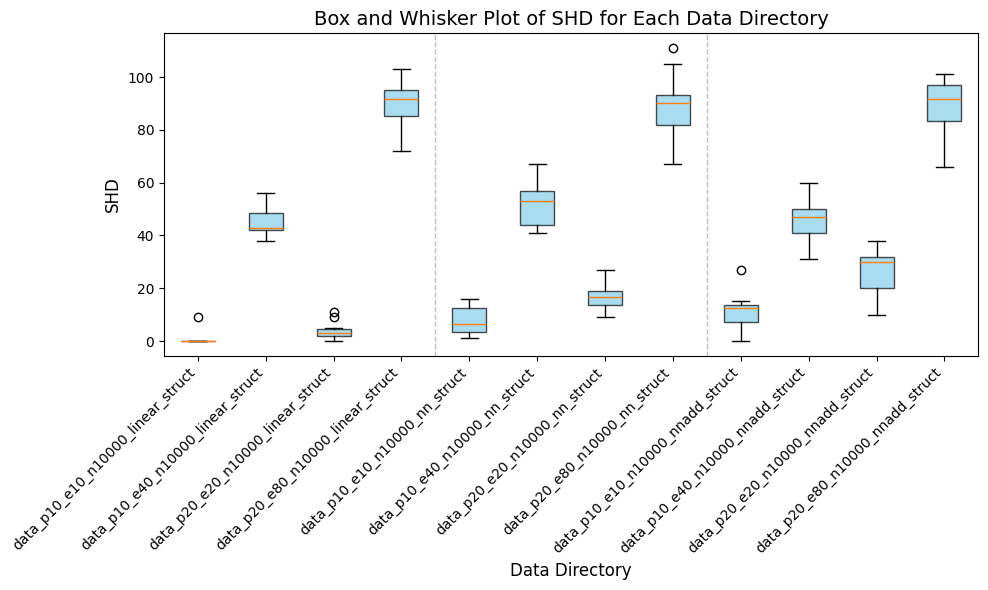

In [98]:
import matplotlib.pyplot as plt

# Prepare data for plotting
data_dirs = []
for struct_type in ['linear_struct', 'nn_struct', 'nnadd_struct']:
    for params in ['p10_e10', 'p10_e40', 'p20_e20', 'p20_e80']:
        dir_name = os.path.join('/cim/ehoney/ift6168_project_v2/ift6168_project/data/perfect/', f'data_{params}_n10000_{struct_type}')
        data_dirs.append(dir_name)
short_data_dirs = [os.path.basename(dir) for dir in data_dirs]  # Extract key info from paths
shd_values_per_dir = [shd_stats_per_dir[dir]['shd_values'] for dir in data_dirs]  # Use SHD values for boxplot

# Calculate group boundaries
group_boundaries = [i * 4 for i in range(1, len(['linear_struct', 'nn_struct', 'nnadd_struct']))]

# Create the plot
plt.figure(figsize=(10, 6))
plt.boxplot(shd_values_per_dir, labels=short_data_dirs, patch_artist=True, boxprops=dict(facecolor='skyblue', alpha=0.7))

# Add vertical lines between groups
for boundary in group_boundaries:
    plt.axvline(x=boundary + 0.5, color='grey', linestyle='--', linewidth=1, alpha=0.5)

plt.xlabel('Data Directory', fontsize=12)
plt.ylabel('SHD', fontsize=12)
plt.title('Box and Whisker Plot of SHD for Each Data Directory', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

# DCDI

In [4]:
!python -m dcdi.main --train --data-path ./data/perfect/data_p10_e10_n10000_linear_struct --num-vars 10 --i-dataset 1 --exp-path exp --model DCDI-DSF --intervention --intervention-type perfect --intervention-knowledge known --reg-coeff 0.5

Detecting 8 CUDA device(s).


In [5]:
!python /cim/ehoney/ift6168_project_v2/ift6168_project/main.py \
    --train \
    --data-path /cim/ehoney/ift6168_project_v2/ift6168_project/data/perfect/data_p10_e10_n10000_linear_struct \
    --num-vars 10 \
    --i-dataset 1 \
    --exp-path /cim/ehoney/ift6168_project_v2/ift6168_project/test_output \
    --model DCDI-DSF \
    --intervention \
    --intervention-type perfect \
    --intervention-knowledge known \
    --reg-coeff 0.5

Detecting 8 CUDA device(s).
torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1691.)
Iteration: 0
    aug-lagrangian: 2.583994032135861
    aug-lagrangian-moving-avg: 0.025839940321358612
    aug-lagrangian-val: 2.405069184200611
    nll: 2.137005810619705
    nll-val: 1.9580809626844544
    nll-gap: -0.17892484793525054
    grad-norm-moving-average: 0.002409611916342415
    delta_gamma: -inf
    omega_gamma: 0.0001
    delta_mu: inf
    omega_mu: 0.9
    constraint_violation: 0.9414970748655984
    acyclicity_violation: 0.941497

In [16]:
!python -m dcdi.main --train --data-path ./data/perfect/data_p10_e10_n10000_linear_struct --num-vars 10 --i-dataset 1 --exp-path ./test_output --model DCDI-DSF --intervention --intervention-type perfect --intervention-knowledge known --reg-coeff 0.5

Detecting 8 CUDA device(s).


In [5]:
os.getcwd()

'/cim/ehoney/IFT6168_project'

In [ ]:
!python ./dcdi/main.py \
    --train \
    --data-path ./dcdi/data/perfect/data_p10_e10_n10000_linear_struct \
    --num-vars 10 \
    --i-dataset 1 \
    --exp-path ./test_exp2 \
    --model DCDI-DSF \
    --intervention \
    --intervention-type perfect \
    --intervention-knowledge known \
    --reg-coeff 0.5 \
    --gpu

Detecting 8 CUDA device(s).
torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
cuda:0
This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1691.)
Iteration: 0
    aug-lagrangian: 2.561228789064346
    aug-lagrangian-moving-avg: 0.025612287890643463
    aug-lagrangian-val: 2.396811388110403
    nll: 2.114240567548191
    nll-val: 1.9498231665942471
    nll-gap: -0.16441740095394364
    grad-norm-moving-average: 0.0023282677481386406
    delta_gamma: -inf
    omega_gamma: 0.0001
    delta_mu: inf
    omega_mu: 0.9
    constraint_violation: 0.9414970748656006
    acyclicity_violation: 

New run after 1:47pm on 6/5/25 after installing R with Conda

In [7]:
!python ./dcdi/main.py \
    --train \
    --data-path /cim/ehoney/IFT6168_project/generated_datasets/data_p10_e20_n500_perfect_intv_test \
    --num-vars 10 \
    --i-dataset 1 \
    --exp-path ./test_after_R \
    --model DCDI-G \
    --intervention \
    --intervention-type perfect \
    --intervention-knowledge known \
    --reg-coeff 0.5 \
    --gpu

Detecting 8 CUDA device(s).
torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
cuda:0
This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1691.)
Iteration: 0
    aug-lagrangian: 2.745556074796531
    aug-lagrangian-moving-avg: 0.027455560747965308
    aug-lagrangian-val: 2.2635864889654185
    nll: 2.2985678532803755
    nll-val: 1.8165982674492627
    nll-gap: -0.4819695858311128
    grad-norm-moving-average: 0.021668175552499235
    delta_gamma: -inf
    omega_gamma: 0.0001
    delta_mu: inf
    omega_mu: 0.9
    constraint_violation: 0.9414970748656006
    acyclicity_violation: 

In [4]:
!python ./dcdi/main.py \
    --train \
    --data-path /cim/ehoney/IFT6168_project/dcdi/data/perfect/data_p10_e10_n10000_linear_struct \
    --num-vars 10 \
    --i-dataset 1 \
    --exp-path ./new_test_after_R_3 \
    --model DCDI-G \
    --intervention \
    --intervention-type perfect \
    --intervention-knowledge known \
    --reg-coeff 0.5 \
    --gpu \
    --plot-freq 1000 \
    --num-folds 1

Detecting 8 CUDA device(s).
torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
cuda:0
This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1691.)
Iteration: 0
    aug-lagrangian: 2.7648868588735613
    aug-lagrangian-moving-avg: 0.027648868588735612
    aug-lagrangian-val: 2.2768998136162137
    nll: 2.317898637357406
    nll-val: 1.829911592100058
    nll-gap: -0.48798704525734804
    grad-norm-moving-average: 0.01992006701035632
    delta_gamma: -inf
    omega_gamma: 0.0001
    delta_mu: inf
    omega_mu: 0.9
    constraint_violation: 0.9414970748656006
    acyclicity_violation: 0

Now test excluding interventions:

In [5]:
!python ./dcdi/main.py \
    --train \
    --data-path /cim/ehoney/IFT6168_project/dcdi/data/perfect/data_p10_e10_n10000_linear_struct \
    --num-vars 10 \
    --i-dataset 1 \
    --exp-path /cim/ehoney/IFT6168_project/experiments/ignore_regime_test \
    --model DCDI-G \
    --intervention \
    --intervention-type perfect \
    --intervention-knowledge known \
    --reg-coeff 0.5 \
    --gpu \
    --plot-freq 1000 \
    --regimes-to-ignore 1 2 3

Detecting 7 CUDA device(s).
torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
cuda:0
This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1691.)
Iteration: 0
    aug-lagrangian: 3.1775163983610333
    aug-lagrangian-moving-avg: 0.031775163983610334
    aug-lagrangian-val: 2.3026132687099077
    nll: 2.730528176844878
    nll-val: 1.8556250471937519
    nll-gap: -0.874903129651126
    grad-norm-moving-average: 0.026519594381298785
    delta_gamma: -inf
    omega_gamma: 0.0001
    delta_mu: inf
    omega_mu: 0.9
    constraint_violation: 0.9414970748656006
    acyclicity_violation: 0